In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

### Load Data

In [210]:
from glob import glob 
glob('./*')

['./Predict_bad_loan.ipynb', './Loan_Dataset.csv', './variable_descriptions']

In [211]:
df = pd.read_csv('Loan_Dataset.csv')

In [212]:
df.head()

,id,grade,annual_income,short_employee,emp_length_num,home_ownership,Debt-To-Income Ratio,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_income          20000 non-null  int64  
 3   short_employee         20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   Debt-To-Income Ratio   19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

### Data Cleaning - Missing Data

In [214]:
#last_major_derog_none - 1 when the loaner has a bad rating for at least 90 days.
df.last_major_derog_none.value_counts()

1.0    436
0.0    138
Name: last_major_derog_none, dtype: int64

In [215]:
#decide how to deal with missing values

#since the majority of the values in last_major_derog_none are missing, dropping the whole column
df.drop(columns= ['last_major_derog_none'], inplace=True)
df.shape

(20000, 14)

In [216]:
df.fillna('NA',inplace=True)

In [217]:
df.home_ownership.value_counts()

MORTGAGE    9844
RENT        7052
OWN         1613
NA          1491
Name: home_ownership, dtype: int64

In [218]:
#is missing values in home_ownership related to the target, bad_loan?
#if yes, then we should not just drop all the rows with missing home_ownership values
#if no, then we can drop those rows
#use chi-square test to test

#table = df.groupby(['bad_loan','home_ownership']).id.agg(['count'])
table = pd.crosstab(df.bad_loan, df.home_ownership,margins=True, margins_name='Total')

table

home_ownership,MORTGAGE,NA,OWN,RENT,Total
bad_loan,,,,,
0,8136,1199,1297,5368,16000
1,1708,292,316,1684,4000
Total,9844,1491,1613,7052,20000


In [219]:
table_2 = list(table.loc[[0,1],'NA']), list(table.loc[[0,1],'Total'])
table_2

([1199, 292], [16000, 4000])

In [220]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_2)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values table:")
print(expected_values)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Reject the null hypothesis. The number of missing values in home_ownership and bad_loan are dependent. Observations with missing home_ownership values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.')

Chi-square statistic: 0.125226721135046
P-value: 0.7234334047142614
Degrees of freedom: 1
Expected values table:
[[ 1193.23014285   297.76985715]
 [16005.76985715  3994.23014285]]
Chi-square Statistic is 0.125226721135046. P-value is 0.7234334047142614. Fail to reject the null hypothesis. The number of missing values in home_ownership and bad_loan are independent. Observations with missing home_ownership values may be dropped. Remaining observations will still represent the population.


In [221]:
row_num_be4 = df.shape[0]
row_num_to_drop = df.home_ownership.value_counts()['NA']

df = df[df.home_ownership!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [222]:
#is missing values in Debt-To-Income Ratio related to the target, bad_loan?
#if yes, then we should not just drop all the rows with missing home_ownership values
#if no, then we can drop those rows
#use chi-square test to test

dti_ratio = df['Debt-To-Income Ratio'].apply(lambda x: 'non-NA' if x != 'NA' else 'NA')
table_3 = pd.crosstab(df.bad_loan, dti_ratio, margins=True, margins_name='Total')
table_3

Debt-To-Income Ratio,NA,non-NA,Total
bad_loan,,,
0,113,14688,14801
1,25,3683,3708
Total,138,18371,18509


In [223]:
chi2_stat, p_value, dof, expected_values = chi2_contingency(table_3)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected values table:")
print(expected_values)

if p_value < 0.05:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are dependent. Observations with missing debt-to-income_ratio values may not be dropped.')
else:
  print(f'Chi-square Statistic is {chi2_stat}. P-value is {p_value}. Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.')

Chi-square statistic: 0.31912447666432636
P-value: 0.988546412334345
Degrees of freedom: 4
Expected values table:
[[  110.35377384 14690.64622616 14801.        ]
 [   27.64622616  3680.35377384  3708.        ]
 [  138.         18371.         18509.        ]]
Chi-square Statistic is 0.31912447666432636. P-value is 0.988546412334345. Fail to reject the null hypothesis. The number of missing values in debt-to-income_ratio and bad_loan are independent. Observations with missing debt-to-income_ratio values may be dropped. Remaining observations will still represent the population.


In [224]:
row_num_be4 = df.shape[0]
row_num_to_drop = df['Debt-To-Income Ratio'].value_counts()['NA']

df = df[df['Debt-To-Income Ratio']!='NA']
row_num_aft = df.shape[0]

assert row_num_aft == row_num_be4 - row_num_to_drop

In [225]:
#change Debt-To-Income Ratio and last_delinq_none to float
df['Debt-To-Income Ratio'] = df['Debt-To-Income Ratio'].astype(float)
df['last_delinq_none'] = df['last_delinq_none'].astype(object)

In [226]:
#clean up term values
df.term.value_counts()
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 Months' else x)
df.term = df.term.apply(lambda x: '36 months' if x == ' 36 months' else x)
df.term = df.term.apply(lambda x: '60 months' if x == ' 60 months' else x)
df.term.value_counts()

36 months    13754
60 months     4617
Name: term, dtype: int64

In [227]:
#after dropping all the rows with missing info, there is no more missing value
(df=='NA').sum(axis=0).sum()

0

### Data Cleaning - Duplicates

In [228]:
df.duplicated().sum()

0

In [229]:
df.describe()

,id,annual_income,short_employee,emp_length_num,Debt-To-Income Ratio,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,1.837100e+04,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000,18371.000000
mean,7.594628e+06,73421.273257,0.112297,6.827609,16.590894,56.001801,0.293404,0.504941,0.200479
std,1.609952e+06,45612.958798,0.315740,3.769322,7.582902,43.411698,3.140913,0.287800,0.400370
min,5.860400e+05,8412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000077,0.000000
25%,6.206280e+06,47000.000000,0.000000,3.000000,10.850000,38.750000,0.000000,0.257495,0.000000
50%,7.379923e+06,65000.000000,0.000000,7.000000,16.220000,57.100000,0.000000,0.507883,0.000000
75%,8.776061e+06,88000.000000,0.000000,11.000000,22.060000,74.000000,0.000000,0.753875,0.000000
max,1.145464e+07,1000000.000000,1.000000,11.000000,34.990000,5010.000000,96.466600,0.999894,1.000000


According to the variable_description file:

Short _ emp - 1 when the borrower has been employed for 1 year or less.
Emp _ length _ num - Number of years worked (in years). It ranges from 0 to 10, 
where 0 means less than a year and 10 means a decade or more.

mmm, i see max is 11 in emp_length_num. not a big deal??

In [230]:
#double check to make sure obs with value 1 in short_employee have emp_length_num <=1

assert (df[df.short_employee==1]['emp_length_num']<=1).mean() ==1

### Data Cleaning - Outliers

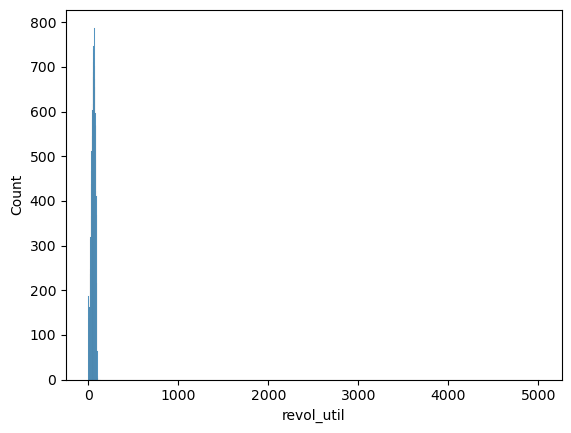

In [231]:
#outliers in revol_util and total_rec_late_fee?
sns.histplot(x='revol_util',data=df)
plt.show()

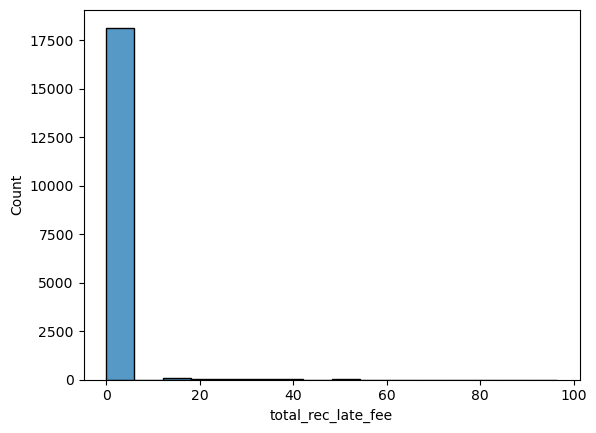

In [232]:
sns.histplot(x='total_rec_late_fee',data=df)
plt.show()

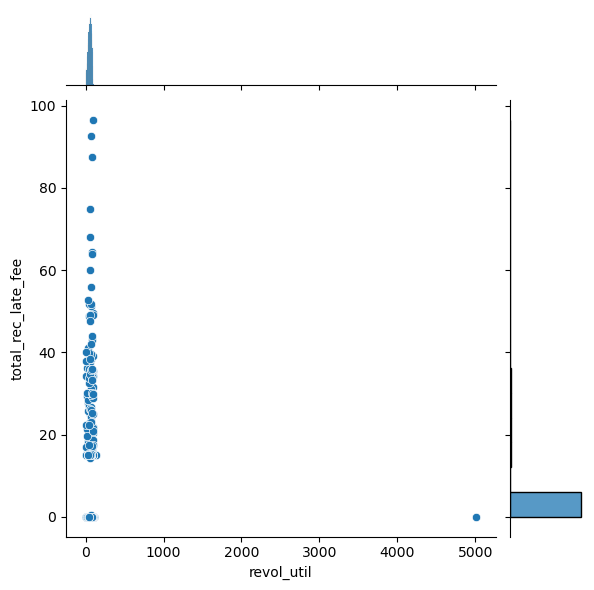

In [233]:
#outliers in revol_util and total_rec_late_fee?
sns.jointplot(x='revol_util',y='total_rec_late_fee',data=df);
plt.show()

In [234]:
df.revol_util.nlargest(10)

100      5010.0
2643      128.1
7880      112.9
19809     109.1
11712     107.7
7208      106.9
16563     106.1
12516     105.8
4948      105.3
17394     103.5
Name: revol_util, dtype: float64

In [235]:
df = df[df.revol_util!=df.revol_util.nlargest(10).iloc[0]]
df.shape

(18370, 14)

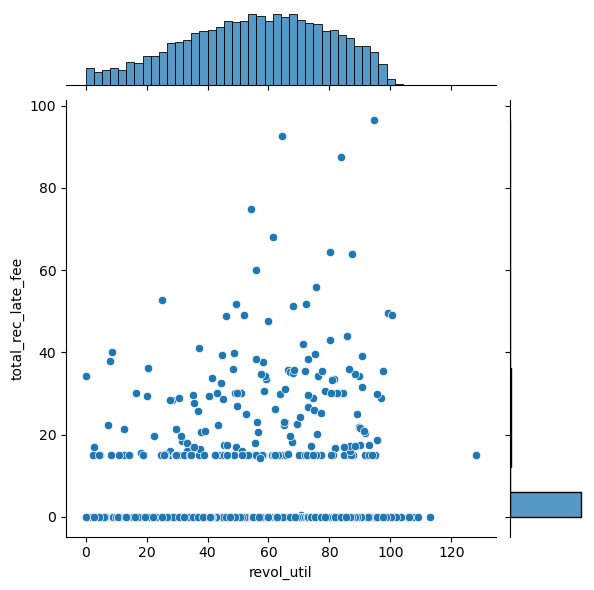

In [236]:
sns.jointplot(x='revol_util',y='total_rec_late_fee',data=df);

In [237]:
df.reset_index(drop=True, inplace=True)

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18370 entries, 0 to 18369
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18370 non-null  int64  
 1   grade                 18370 non-null  object 
 2   annual_income         18370 non-null  int64  
 3   short_employee        18370 non-null  int64  
 4   emp_length_num        18370 non-null  int64  
 5   home_ownership        18370 non-null  object 
 6   Debt-To-Income Ratio  18370 non-null  float64
 7   purpose               18370 non-null  object 
 8   term                  18370 non-null  object 
 9   last_delinq_none      18370 non-null  object 
 10  revol_util            18370 non-null  float64
 11  total_rec_late_fee    18370 non-null  float64
 12  od_ratio              18370 non-null  float64
 13  bad_loan              18370 non-null  int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 2.0+ MB


Loan default is a rare case:

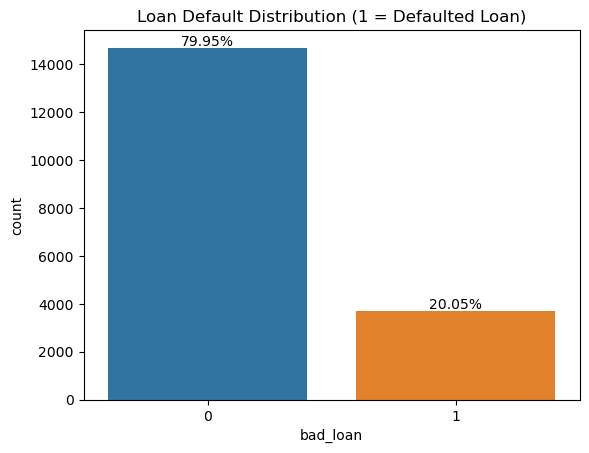

In [239]:
total_count = df.bad_loan.size

ax = sns.countplot(x='bad_loan', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

### Visualization of Categorical Features' Distributions

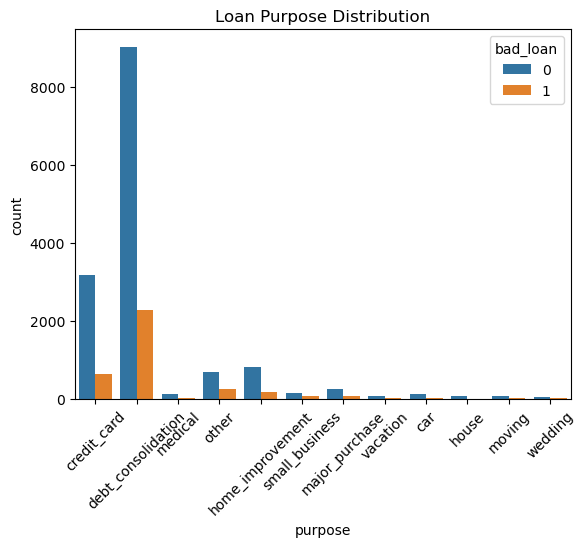

In [240]:
sns.countplot(x=df.purpose, hue=df.bad_loan);
plt.xticks(rotation=45)
plt.title('Loan Purpose Distribution');

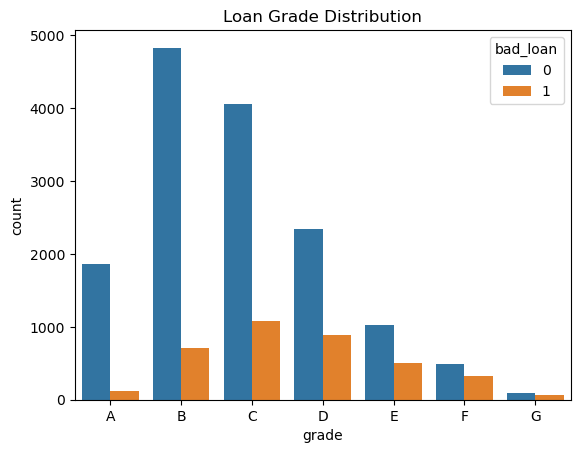

In [241]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order);
plt.title('Loan Grade Distribution');

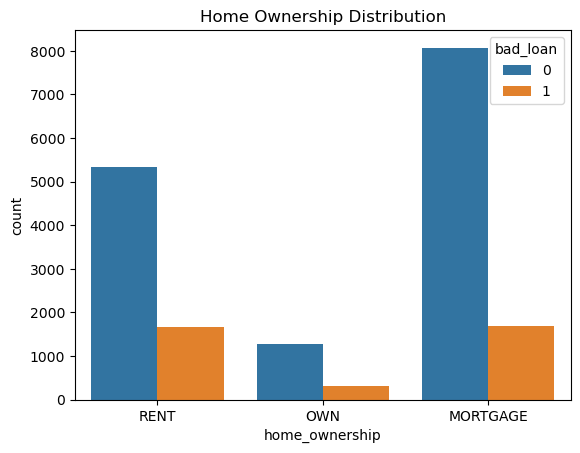

In [242]:
sns.countplot(x=df.home_ownership, hue=df.bad_loan);
plt.title('Home Ownership Distribution');

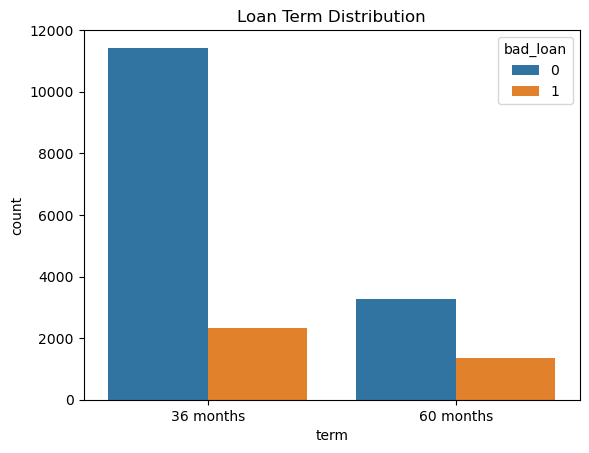

In [243]:
sns.countplot(x=df.term, hue=df.bad_loan);
plt.title('Loan Term Distribution');

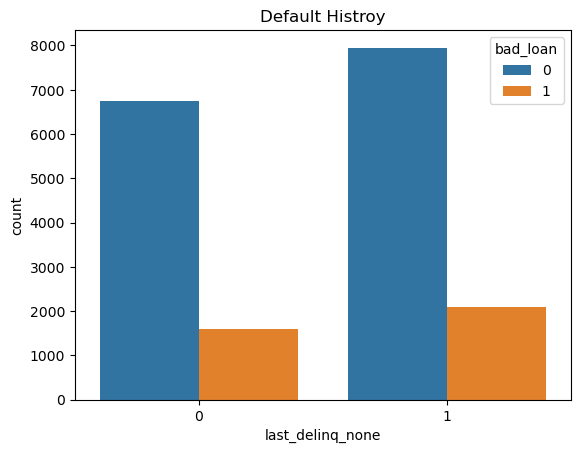

In [244]:
#Last _ delinq _ none - 1 when the debit has been in default at least once.
sns.countplot(x=df.last_delinq_none, hue=df.bad_loan);
plt.title('Default Histroy');

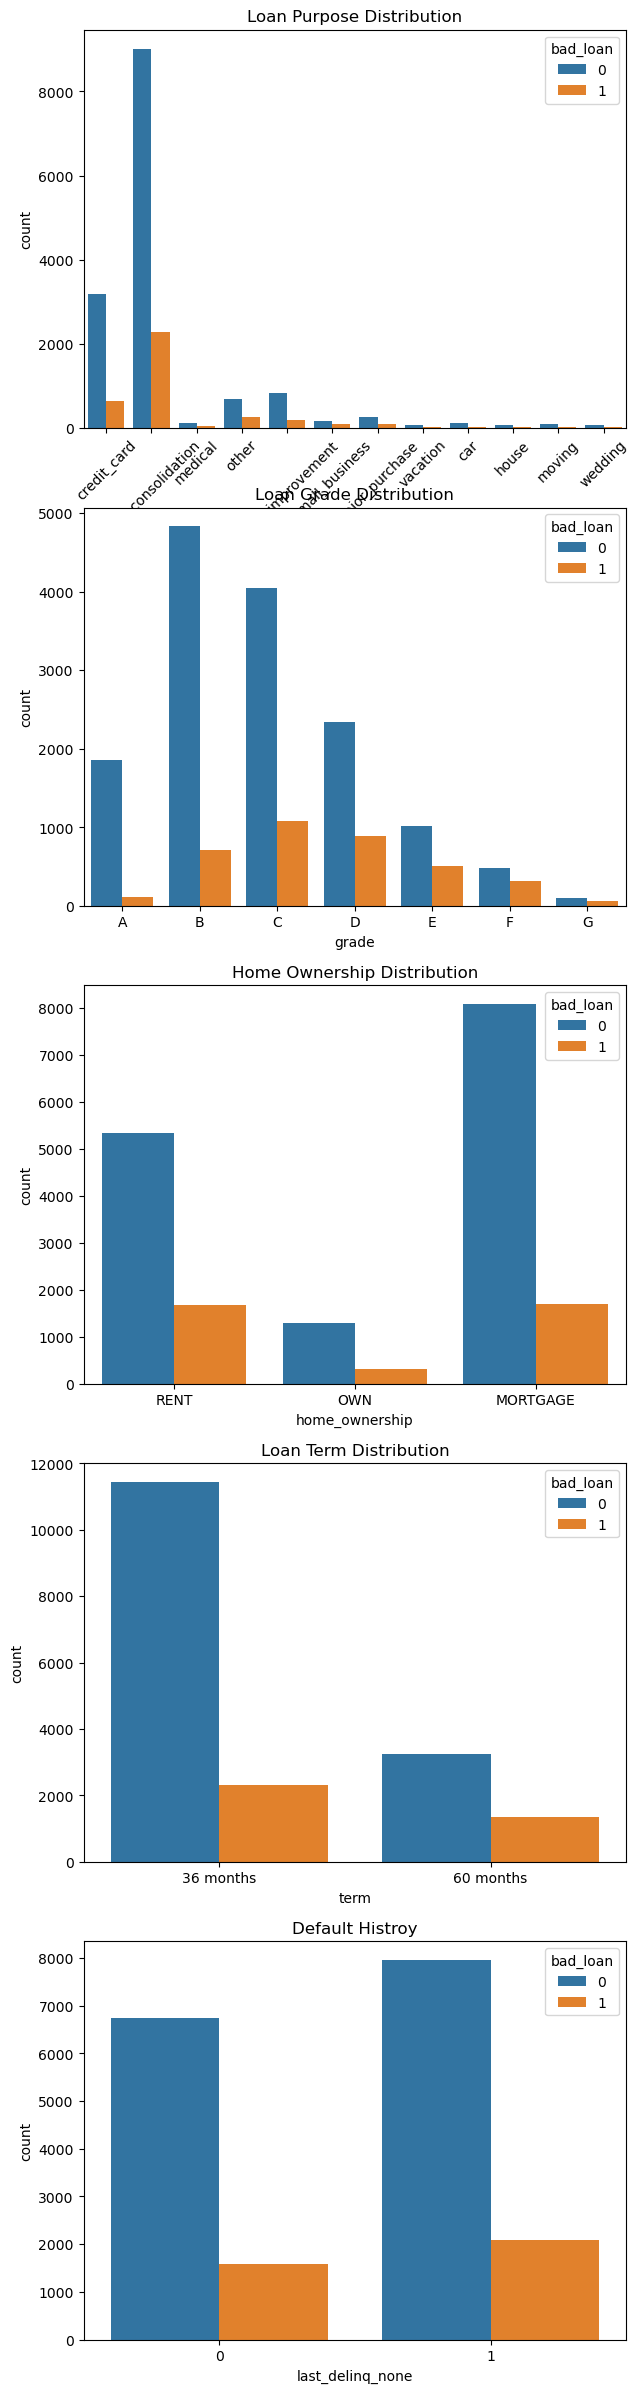

In [245]:
fig,ax = plt.subplots(5,1,figsize=(7,30))

sns.countplot(x=df.purpose, hue=df.bad_loan, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Loan Purpose Distribution');

sns.countplot(x=df.grade, hue=df.bad_loan, order=grade_order, ax=ax[1]);
ax[1].set_title('Loan Grade Distribution');

sns.countplot(x=df.home_ownership, hue=df.bad_loan, ax=ax[2]);
ax[2].set_title('Home Ownership Distribution');

sns.countplot(x=df.term, hue=df.bad_loan, ax=ax[3]);
ax[3].set_title('Loan Term Distribution');

sns.countplot(x=df.last_delinq_none, hue=df.bad_loan, ax=ax[4]);
ax[4].set_title('Default Histroy');


### Visualization of Continuous Features' Distributions

Histograms

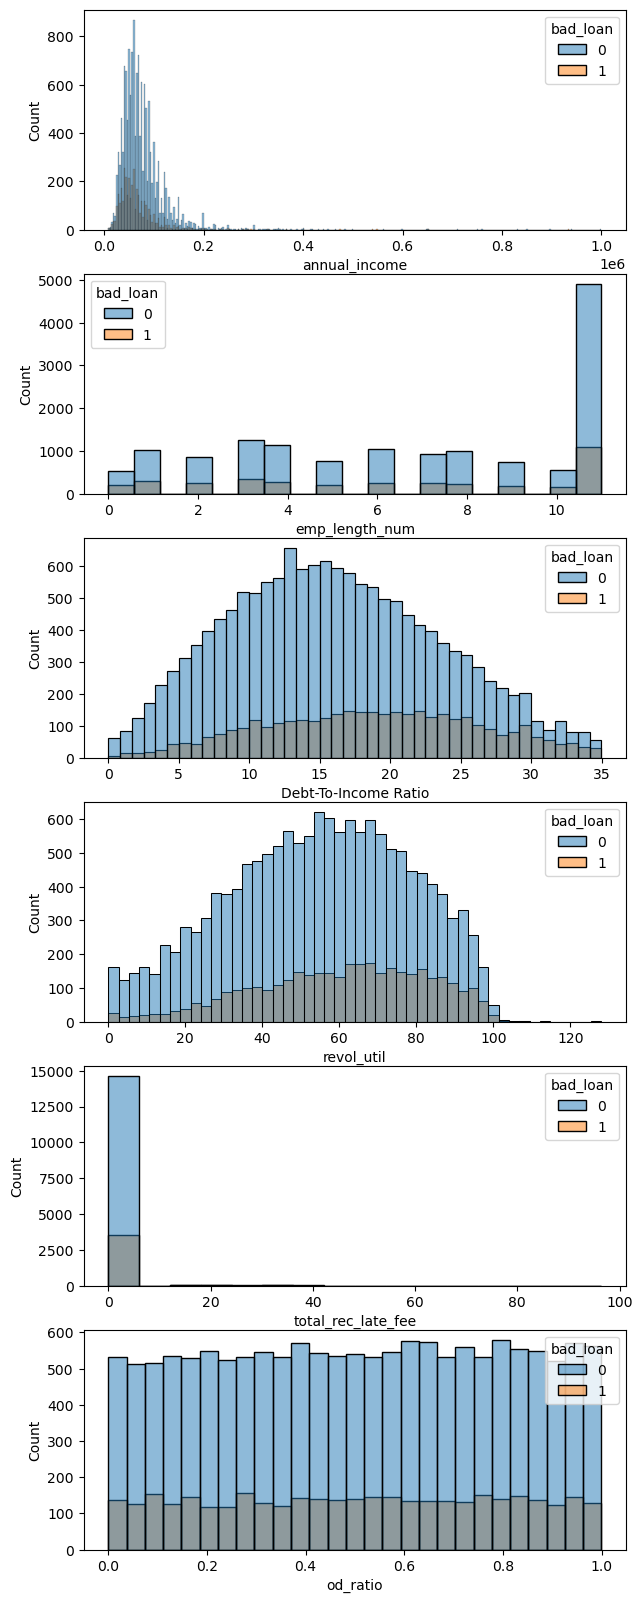

In [246]:
fig,ax = plt.subplots(6,1,figsize=(7,20))

sns.histplot(x='annual_income',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[0]);

sns.histplot(x='emp_length_num',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[1]);

sns.histplot(x='Debt-To-Income Ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.histplot(x='revol_util',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.histplot(x='total_rec_late_fee',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[4]);

sns.histplot(x='od_ratio',
                hue = 'bad_loan', 
                data=df, 
                ax=ax[5]);

Boxplots

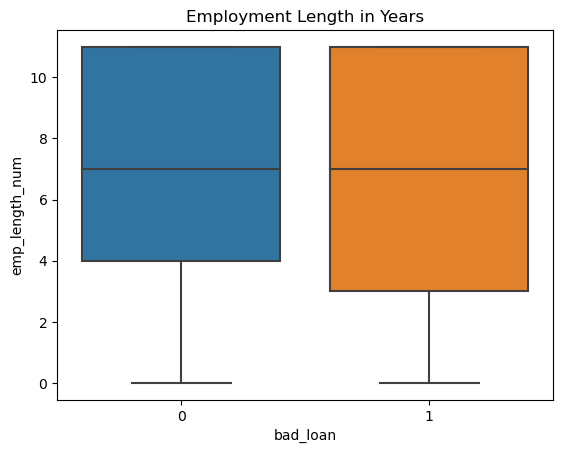

In [247]:
sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df);
plt.title('Employment Length in Years')
plt.show()

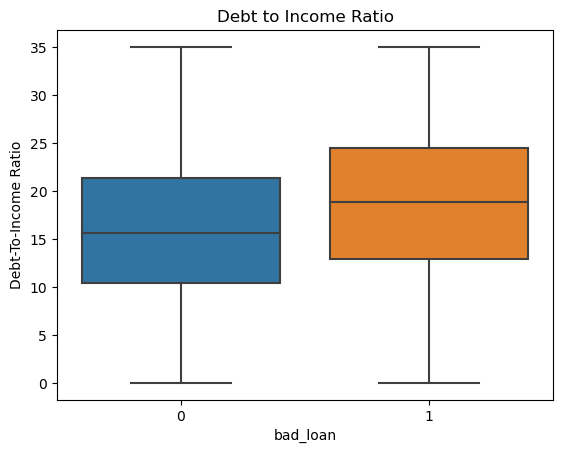

In [248]:
sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df);
plt.title('Debt to Income Ratio')
plt.show()

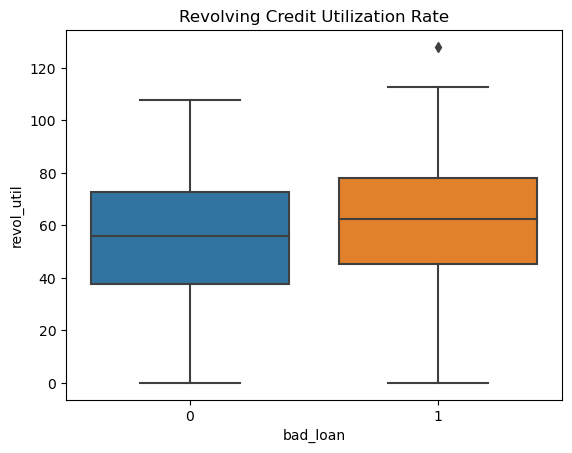

In [249]:
sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df);
plt.title('Revolving Credit Utilization Rate')
plt.show()

In [250]:
df.total_rec_late_fee[df.total_rec_late_fee != 0].sort_values()

10246     0.0100
8570      0.0100
12960     0.3500
14721    14.2350
3456     14.9394
          ...   
9672     68.1100
12936    74.9400
7201     87.5200
12709    92.5200
16034    96.4666
Name: total_rec_late_fee, Length: 212, dtype: float64

In [251]:
total_rec_late_fee_not0_df = df[df.total_rec_late_fee != 0]

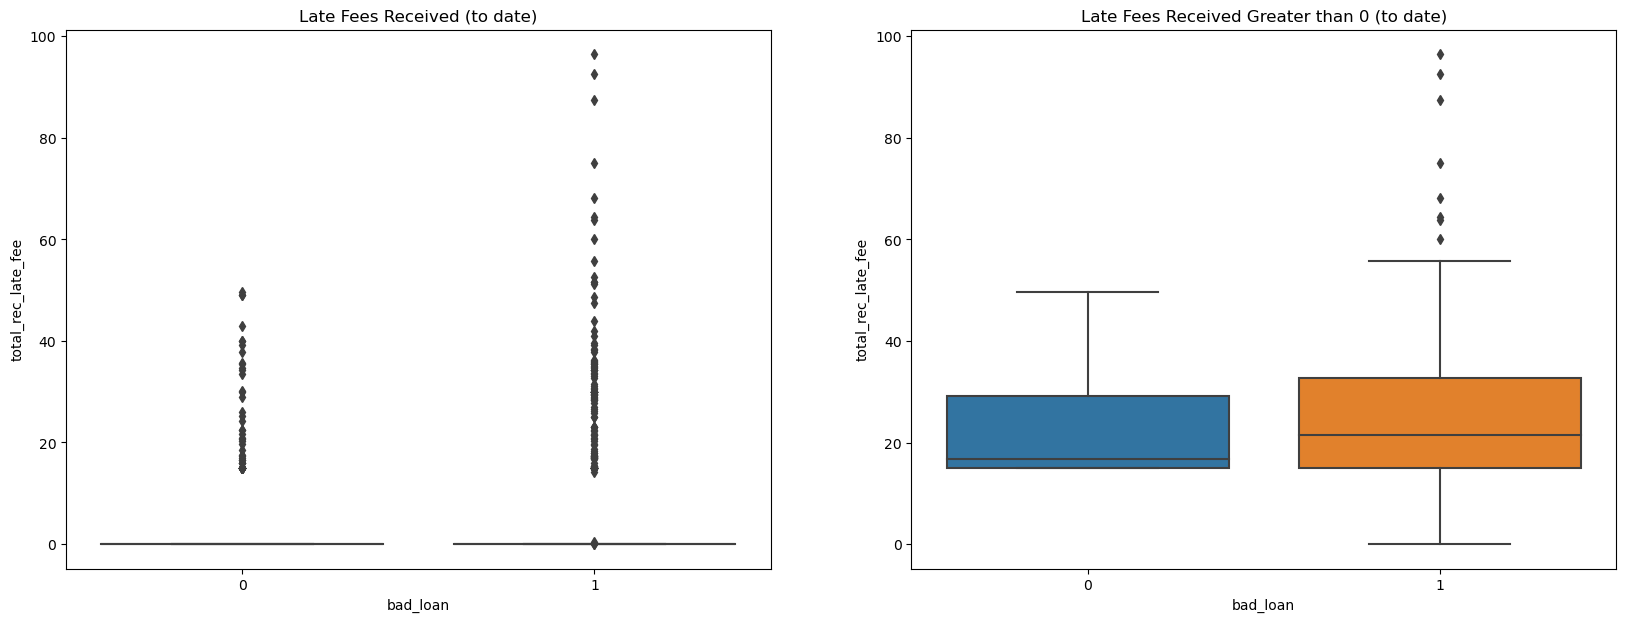

In [252]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=df,
            ax=ax[0]);
ax[0].set_title('Late Fees Received (to date)');

#'zoom in' to late fees that are not zero
sns.boxplot(y='total_rec_late_fee',
            x = 'bad_loan', 
            data=total_rec_late_fee_not0_df,
            ax=ax[1]);
ax[1].set_title('Late Fees Received Greater than 0 (to date)');

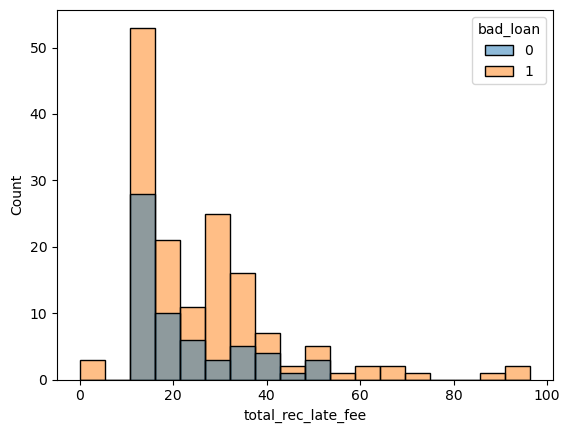

In [253]:
sns.histplot(x='total_rec_late_fee',
                hue = 'bad_loan', 
                data=total_rec_late_fee_not0_df)
plt.show()

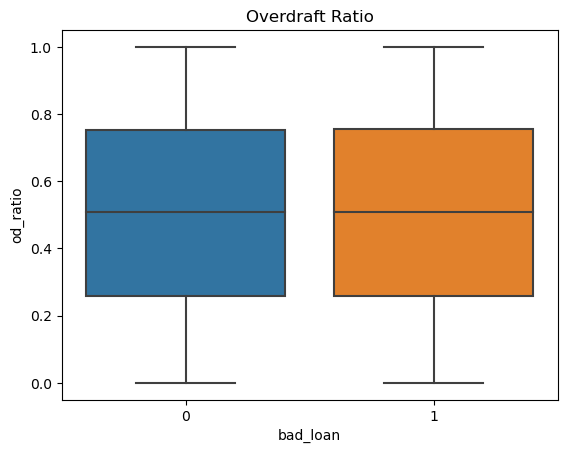

In [254]:
sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df);
plt.title('Overdraft Ratio')
plt.show()

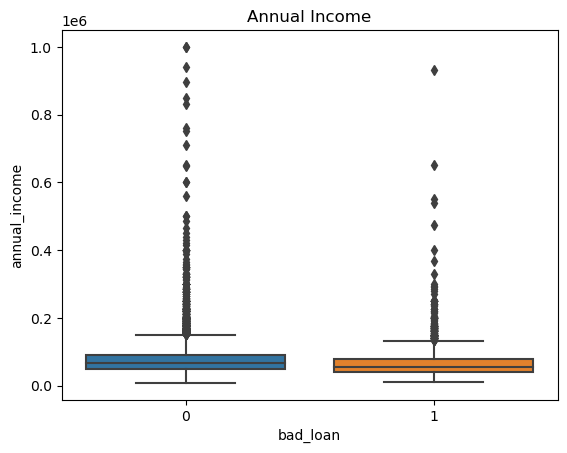

In [255]:
sns.boxplot(y='annual_income',
                x = 'bad_loan', 
                data=df);
plt.title('Annual Income')
plt.show()

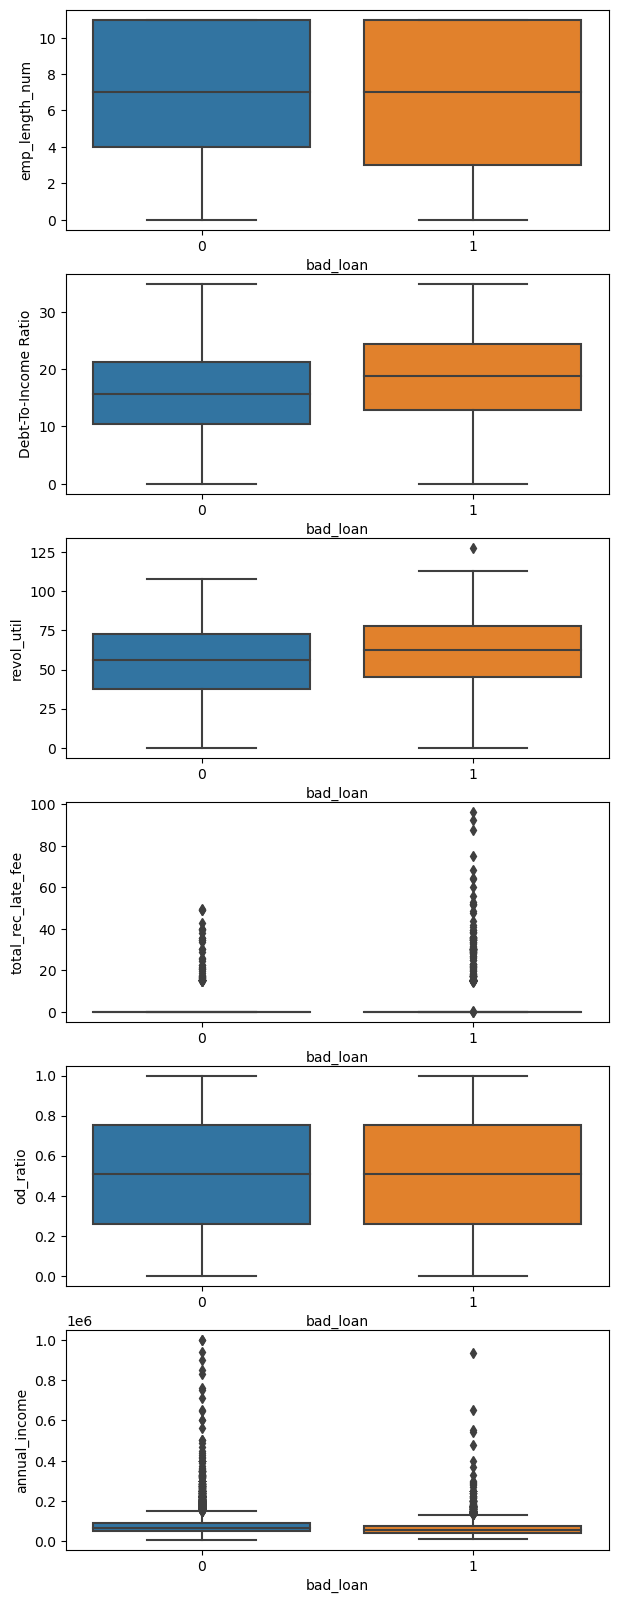

In [256]:
fig,ax = plt.subplots(6,1,figsize=(7,20))

#sns.boxplot(x=df.emp_length_num, y=df.bad_loan, ax=ax[0]);

sns.boxplot(y='emp_length_num',
                x ='bad_loan',
                data=df, 
                ax=ax[0]);

sns.boxplot(y='Debt-To-Income Ratio',
                x='bad_loan',
                data=df, 
                ax=ax[1]);

sns.boxplot(y='revol_util',
                x = 'bad_loan', 
                data=df, 
                ax=ax[2]);

sns.boxplot(y='total_rec_late_fee',
                x = 'bad_loan', 
                data=df, 
                ax=ax[3]);

sns.boxplot(y='od_ratio',
                x = 'bad_loan', 
                data=df, 
                ax=ax[4]);

sns.boxplot(y='annual_income',
                x = 'bad_loan', 
                data=df, 
                ax=ax[5]);

### Data Cleaning - Dealing With Skew

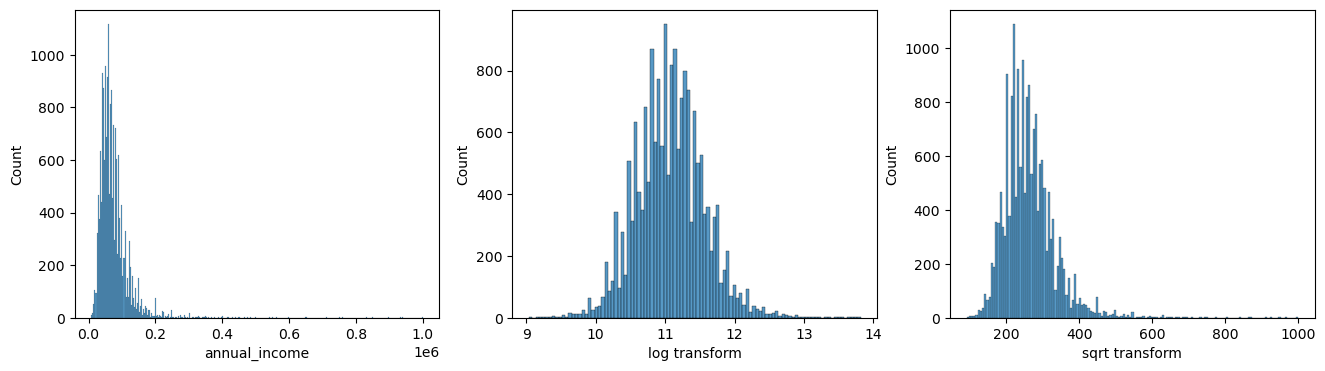

In [257]:
#annual_income looks very skewed. Try trainsforming the feature using log or sqrt.
#but may not need transformation for non-linear classifiers??
fig, ax = plt.subplots(1, 3, figsize = (16,4))
sns.histplot(x=df.annual_income, ax=ax[0]);
sns.histplot(x=df.annual_income.apply(lambda x: x+1).apply(np.log), ax=ax[1]);
ax[1].set_xlabel('log transform');
sns.histplot(x=df.annual_income.apply(np.sqrt), ax=ax[2]);
ax[2].set_xlabel('sqrt transform');

In [258]:
df['annual_income_log'] = df.annual_income.apply(lambda x: x+1).apply(np.log)

In [259]:
pd.get_dummies(df).shape

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


(18370, 36)

In [260]:
pd.get_dummies(df).columns

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Index(['id', 'annual_income', 'short_employee', 'emp_length_num',
       'Debt-To-Income Ratio', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'annual_income_log', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36 months', 'term_60 months', 'last_delinq_none_0',
       'last_delinq_none_1'],
      dtype='object')

In [261]:
df.shape

(18370, 15)

In [262]:
df = pd.get_dummies(df)

/Users/kaimihuang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [323]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [264]:
help(StratifiedShuffleSplit)

Help on class StratifiedShuffleSplit in module sklearn.model_selection._split:

class StratifiedShuffleSplit(BaseShuffleSplit)
 |  StratifiedShuffleSplit(n_splits=10, *, test_size=None, train_size=None, random_state=None)
 |  
 |  Stratified ShuffleSplit cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets.
 |  
 |  This cross-validation object is a merge of StratifiedKFold and
 |  ShuffleSplit, which returns stratified randomized folds. The folds
 |  are made by preserving the percentage of samples for each class.
 |  
 |  Note: like the ShuffleSplit strategy, stratified random splits
 |  do not guarantee that all folds will be different, although this is
 |  still very likely for sizeable datasets.
 |  
 |  Read more in the :ref:`User Guide <stratified_shuffle_split>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=10
 |      Number of re-shuffling & splitting iterations.
 |  
 |  test_size : float or int, default=None
 |      If float

In [324]:
X = df.drop(columns=['id', 'annual_income','bad_loan','grade_A',
                     'home_ownership_MORTGAGE','purpose_car','term_36 months',
                     'last_delinq_none_0'])

y = df['bad_loan'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8)
train_ind, test_ind = next(sss.split(X,y,groups=None))

In [325]:
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

In [326]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [327]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [352]:
param_grid = [
    {'n_estimators': [450, 500, 550, 600, 700],
     'max_depth': [10, 15, 20, 25],
     'learning_rate': [0.1, 0.2, 0.3]}
]

In [353]:
xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = make_scorer(recall_score),
                          return_train_score = True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [354]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 600}

In [355]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.15580213519035424 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 450}
0.15342522517337628 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
0.15987511150758255 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 550}
0.16259330666743405 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 600}
0.16734655117838335 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 700}
0.1588610399700728 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 450}
0.16055825731633624 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
0.16361255791200252 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 550}
0.16531092630427902 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600}
0.16700987021956204 {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 700}
0.154787488129838 {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 450}
0.15852205691922536 {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
0.16021927426548874 {'learning_

In [356]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='logloss',
                                    learning_rate=0.3,
                                    max_depth=10,
                                    n_estimators=600,
                                    scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[2842   95]
 [ 671   66]]

Accuracy: 0.7915078933043005

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      2937
           1       0.41      0.09      0.15       737

    accuracy                           0.79      3674
   macro avg       0.61      0.53      0.51      3674
weighted avg       0.73      0.79      0.73      3674



In [357]:
threshold = 0.03
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy：", accuracy)

                #Predicted Negative     Predicted Positive
#Actual Negative       TN                     FP
#Actual Positive       FN                     TP

Confusion Matrix:
[[2155  782]
 [ 454  283]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2937
           1       0.27      0.38      0.31       737

    accuracy                           0.66      3674
   macro avg       0.55      0.56      0.55      3674
weighted avg       0.71      0.66      0.68      3674

Accuracy： 0.663581927054981


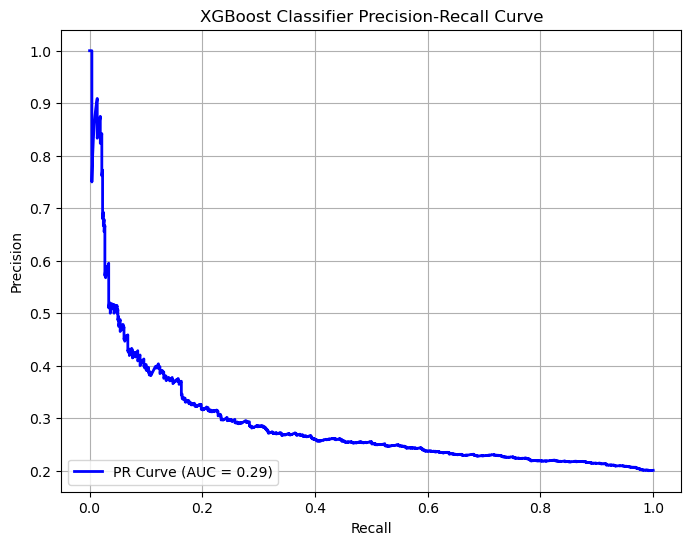

In [358]:
xgb_precision, xgb_recall, xgb_thresholds = precision_recall_curve(y_test, y_pred_prob)

xgb_pr_auc = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(xgb_recall, xgb_precision, color='b', lw=2, label=f'PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [857]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, class_weight=class_weights)),
    ('gb', GradientBoostingClassifier(max_depth=20, learning_rate=0.1, n_estimators=200)),
    ('xgb', xgb.XGBClassifier(random_state=42, scale_pos_weight=class_weights[0]/class_weights[1])),
]

meta_learner = LogisticRegression(class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]
# threshold = 0.5 
# y_pred = (y_pred_prob >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy：", accuracy)

Confusion Matrix:
[[2062  875]
 [ 350  387]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      2937
           1       0.31      0.53      0.39       737

    accuracy                           0.67      3674
   macro avg       0.58      0.61      0.58      3674
weighted avg       0.74      0.67      0.69      3674


Accuracy： 0.6665759390310289


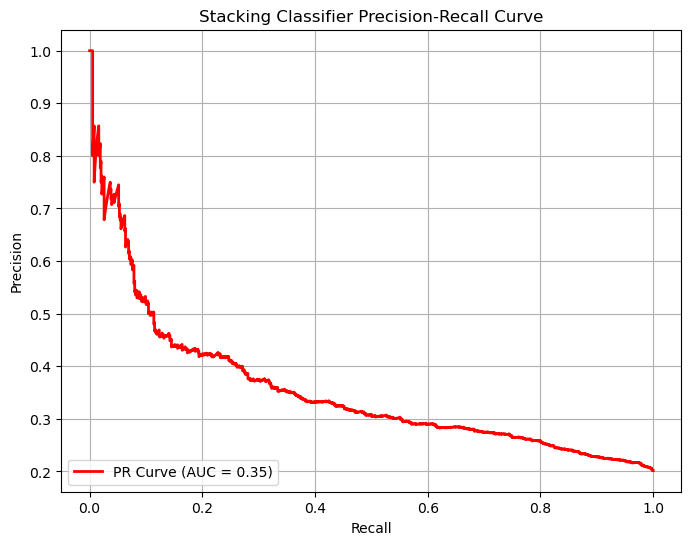

In [858]:
stacking_precision, stacking_recall, stacking_thresholds = precision_recall_curve(y_test, y_pred_prob)

stacking_pr_auc = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(stacking_recall, stacking_precision, color='r', lw=2, label=f'PR Curve (AUC = {stacking_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Stacking Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [859]:
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]
threshold = 0.375
y_pred = (y_pred_prob >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy：", accuracy)

Confusion Matrix:
[[ 977 1960]
 [ 113  624]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.33      0.49      2937
           1       0.24      0.85      0.38       737

    accuracy                           0.44      3674
   macro avg       0.57      0.59      0.43      3674
weighted avg       0.76      0.44      0.46      3674


Accuracy： 0.4357648339684268


In [860]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None, 
    class_weight=class_weights,
)

rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

y_scores = rf_classifier.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred = (y_scores > threshold).astype(int)

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nRandom Forest Accuracy：", accuracy)

Random Forest Confusion Matrix:
[[ 983 1954]
 [ 107  630]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.33      0.49      2937
           1       0.24      0.85      0.38       737

    accuracy                           0.44      3674
   macro avg       0.57      0.59      0.43      3674
weighted avg       0.77      0.44      0.47      3674


Random Forest Accuracy： 0.4390310288513881


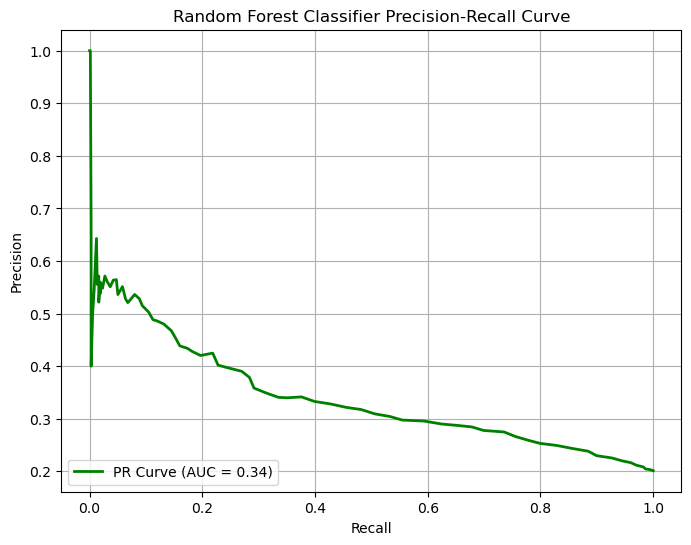

In [861]:
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, y_scores)

rf_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'PR Curve (AUC = {rf_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [862]:
from sklearn.linear_model import SGDClassifier

batch_size = 50

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        max_iter=1000,
                        tol=1e-3
                        )

for epoch in range(50):

    mini_batches = [(X_train[i:i + batch_size], y_train[i:i + batch_size])
                    for i in range(0, X_train.shape[0], batch_size)]

    for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        sgd_clf.partial_fit(X_mini, y_mini, classes=np.unique(y_train))

y_scores = sgd_clf.predict_proba(X_test)[:, 1]
# threshold = 0.5 
# y_pred = (y_scores > threshold).astype(int)

print("SGD Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nSGD Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("\nSGD Accuracy：", accuracy)


SGD Confusion Matrix:
[[ 983 1954]
 [ 107  630]]

SGD Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.33      0.49      2937
           1       0.24      0.85      0.38       737

    accuracy                           0.44      3674
   macro avg       0.57      0.59      0.43      3674
weighted avg       0.77      0.44      0.47      3674


SGD Accuracy： 0.4390310288513881


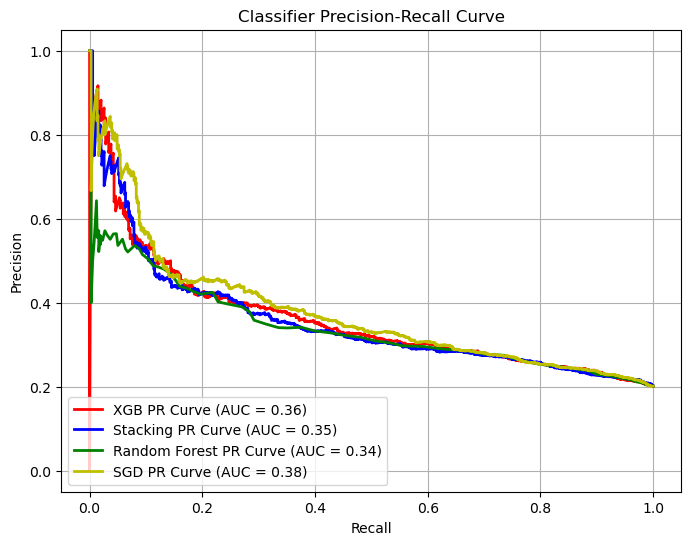

In [863]:
sgd_precision, sgd_recall, sgd_thresholds = precision_recall_curve(y_test, y_scores)

sgd_pr_auc = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stacking_recall, stacking_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stacking_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(sgd_recall, sgd_precision, color='y', lw=2, label=f'SGD PR Curve (AUC = {sgd_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()